<a href="https://colab.research.google.com/github/eduardojdiniz/Buzznauts/blob/master/scripts/baseline_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model: Predicting fMRI responses from Algonauts2021 dataset

**Goal:** Prepare submission for Algonauts 2021 challenge using baseline model (i.e., AlexNet) as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Feedforward the videos from stimulus set to the AlexNet model pretrained on Imagenet dataset to extract AlexNet activations from different layers and apply PCA for dimensionality reduction.
3. Train a linear regression to predict fMRI responses from AlexNet activations.
4. Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set. 
5. Generate predicted fMRI responses to test videos for all subjects all ROIs.
6. Preparing submission files for codalab.

### Setup 

In [ ]:
# Install dependencies and Download Buzznauts
%%capture

!pip install duecredit --quiet
!pip install nilearn --quiet
!pip install decord --quiet
!pip install torchinfo --quiet
!pip install git+https://github.com/eduardojdiniz/Buzznauts --quiet

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Import interactive tools
from ipywidgets import widgets
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# Set videos and annotation file path
import os
import os.path as op
from pathlib import Path

drive_root = "/content/drive/MyDrive/Buzznauts"

# Data paths
fmri_dir = op.join(drive_root, "data", "fmri")
stimuli = op.join(drive_root, "data", "stimuli") 
videos_dir = op.join(stimuli, "videos")
frames_dir = op.join(stimuli, "frames")

# Visualizations path
viz_dir = "/content/visualizations"
viz_baseline_dir = op.join(vir_dir, "models", "baseline")

# Model path
models_dir = "/content/models/baseline"

# Results paths
results_dir = "/content/results/baseline"
activations_dir = op.join(results_dir, "activations")
activations_pca_dir = op.join(activations_dir, "pca_100")

In [ ]:
from Buzznauts.utils import set_seed, seed_worker, set_generator

# Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge. 

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.
 

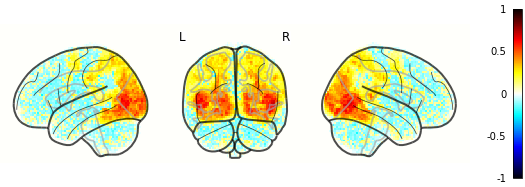

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body - EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


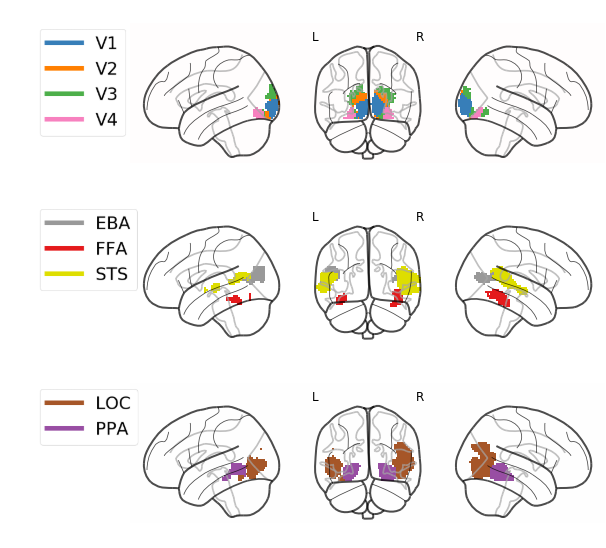

## Loading fMRI Data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. `V1.pkl`) that contains a `num_videos x num_repetitions x num_voxels matrix`. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. `WB.pkl`) that contains a `num_videos x num_repetitions x num_voxels` matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [ ]:
from Buzznauts.utils import get_fmri 

sub = ["sub01", "sub02", "sub03", "sub04", "sub05", "sub06", "sub07", "sub08", "sub09", "sub10"]
ROI = ["WB", "V1", "V2", "V3", "V4", "LOC", "EBA", "FFA", "STS", "PPA"]
@widgets.interact(fmri_dir=widgets.fixed(fmri_dir),
                  ROI=widgets.Dropdown(options=ROI, value="LOC", description="ROI"), 
                  sub=widgets.Dropdown(options=sub, value="sub04", description="Subject"),
                  viz_dir=widgets.fixed(viz_dir))
def fMRI_dataloader(fmri_dir, ROI, sub):
    track = "full_track" if ROI == "WB" else "mini_track"
    track_dir = op.join(fmri_dir, track) 
    sub_fmri_dir = op.join(track_dir, sub)
    if track == "full_track":
        fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir, ROI)
    else:
        fmri_train_all = get_fmri(sub_fmri_dir, ROI)

    # Plot response
    plt.close('all')
    f, ax = plt.subplots(figsize=(12, 5))
    ax.set(xlabel="Voxel", ylabel="Stimulus", title=f'ROI: {ROI}, sub: {sub}')
    heatmap = ax.imshow(fmri_train_all, aspect="auto", cmap='jet', vmin=-1, vmax=1)
    f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    f.tight_layout()
    fig_name = op.join(viz_dir, track, sub, f"{ROI}_fMRI_response.jpg")
    fig_dir = Path(fig_name).parent.absolute()
    if not op.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(fig_name)
    plt.close(f)
    
    image = Image.from_file(fig_name)
    display(image)

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI data were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html). 

## Vizualize Stimulus

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [ ]:
import glob
from Buzznauts.data.utils import visualize_activity_glass
from ipywidgets import Video, Image, VBox, HBox, Layout, Play

sub = ["sub01", "sub02", "sub03", "sub04", "sub05", "sub06", "sub07", "sub08", "sub09", "sub10"]
sub=widgets.Dropdown(options=sub, value="sub04", description="Subject")

videos_list = glob.glob(videos_dir + '/*.mp4')
videos_list.sort()
#video_id=widgets.IntSlider(min=0, max=999, step=1, value=266, description='video id')
video_id=widgets.Play(min=0, max=999, step=1, value=0, interval=4000, description='Press Play')

save_dir = "results/baseline/layer_5"
@widgets.interact(videos_list=widgets.fixed(videos_list), video_id=video_id, sub=sub,
                  fmri_dir=widgets.fixed(fmri_dir), save_dir=widgets.fixed(viz_dir)) 
def visualize_video_and_brain_activity(videos_list, fmri_dir, save_dir, video_id=0, sub='sub04'):
    kwargs = {"video_id": video_id, "fmri_dir": fmri_dir, "save_dir": save_dir}
    jpg_image = visualize_activity_glass(sub, **kwargs)
    
    video_box_layout = Layout(display='flex', flex_flow='column', align_items='stretch',
                              border='solid', width='27.5%')
    image_box_layout = Layout(display='flex', flex_flow='column', align_items='stretch',
                              border='solid', width='75%')
    video = Video.from_file(videos_list[video_id], loop=False)
    image = Image.from_file(jpg_image)
    video_box = VBox([video], layout=video_box_layout) 
    image_box = VBox([image], layout=image_box_layout) 
    w = HBox([video_box, image_box])
    display(w)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Vision Model Definition (AlexNet)

Pytorch based AlexNet is used as the vision model

In [ ]:
from Buzznauts.utils import set_seed, seed_worker, set_generator, set_device
# Set random generators' seed to ensure reproducibility
seed = set_seed(seed=12345)
# Set computational device (cuda if GPU is available, else cpu)
device = set_device()

In [ ]:
from Buzznauts.models.baseline.alexnet import load_alexnet
from torchinfo import summary

checkpoint_path = op.join(models_dir, "alexnet.pth")
model = load_alexnet(ckpth=checkpoint_path, pretrained=True, custom_keys=True)
model.to(device)
model.eval()

summary(model, input_size = (64, 3, 224, 224))

## Feature Extraction
Extract Alexnet activations on the videos from the stimulus set. 

In [ ]:
from Buzznauts.analysis.baseline import get_activations_and_save

imagenet_file = op.join(models_dir, 'imagenet_labels.txt')
if not op.exists(activations_dir):
    os.makedirs(activations_dir)
predictions = get_activations_and_save(model, frames_dir, imagenet_file,
                                       activations_dir, device=device)

In [ ]:
import glob
from Buzznauts.data.utils import visualize_activity_glass
from ipywidgets import Video, Image, VBox, HBox, Layout, Play

videos_list = glob.glob(videos_dir + '/*.mp4')
videos_list.sort()
#video_id=widgets.IntSlider(min=0, max=999, step=1, value=266, description='video id')
video_id=widgets.Play(min=0, max=999, step=1, value=0, interval=4000, description='Press Play')

save_dir = "results/baseline/layer_5"
@widgets.interact(videos_list=widgets.fixed(videos_list), video_id=video_id,
                  predictions=widgets.fixed(predictions)) 
def vizualize_alexnet_predictions(videos_list, predictions, video_id=0):
    video_box_layout = Layout(display='flex', flex_flow='column', align_items='stretch',
                              border='solid', width='27.5%')
    text_box_layout = Layout(display='flex', flex_flow='column', align_items='stretch',
                              border='solid', width='75%')
    video = Video.from_file(videos_list[video_id], loop=False)
    prediction = predictions[video_id]
    prediction_text = '<p><b>Top-5 predictions for video:</b></p>'
    for i in range(0, 5):
        prediction_text += f"<p><b>{i+1} -</b> {prediction[i][0]}: {prediction[i][1]:.4f}%</p>"
    text = widgets.HTML(value=prediction_text)
    video_box = VBox([video], layout=video_box_layout) 
    text_box = VBox([text], layout=text_box_layout) 
    w = HBox([video_box, text_box])
    display(w)

Preprocessing using PCA and saving the first 100 Principal Components 

In [ ]:
from Buzznauts.analysis.baseline import do_PCA_and_save 

do_PCA_and_save(activations_dir, activations_pca_dir, seed=seed)

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 

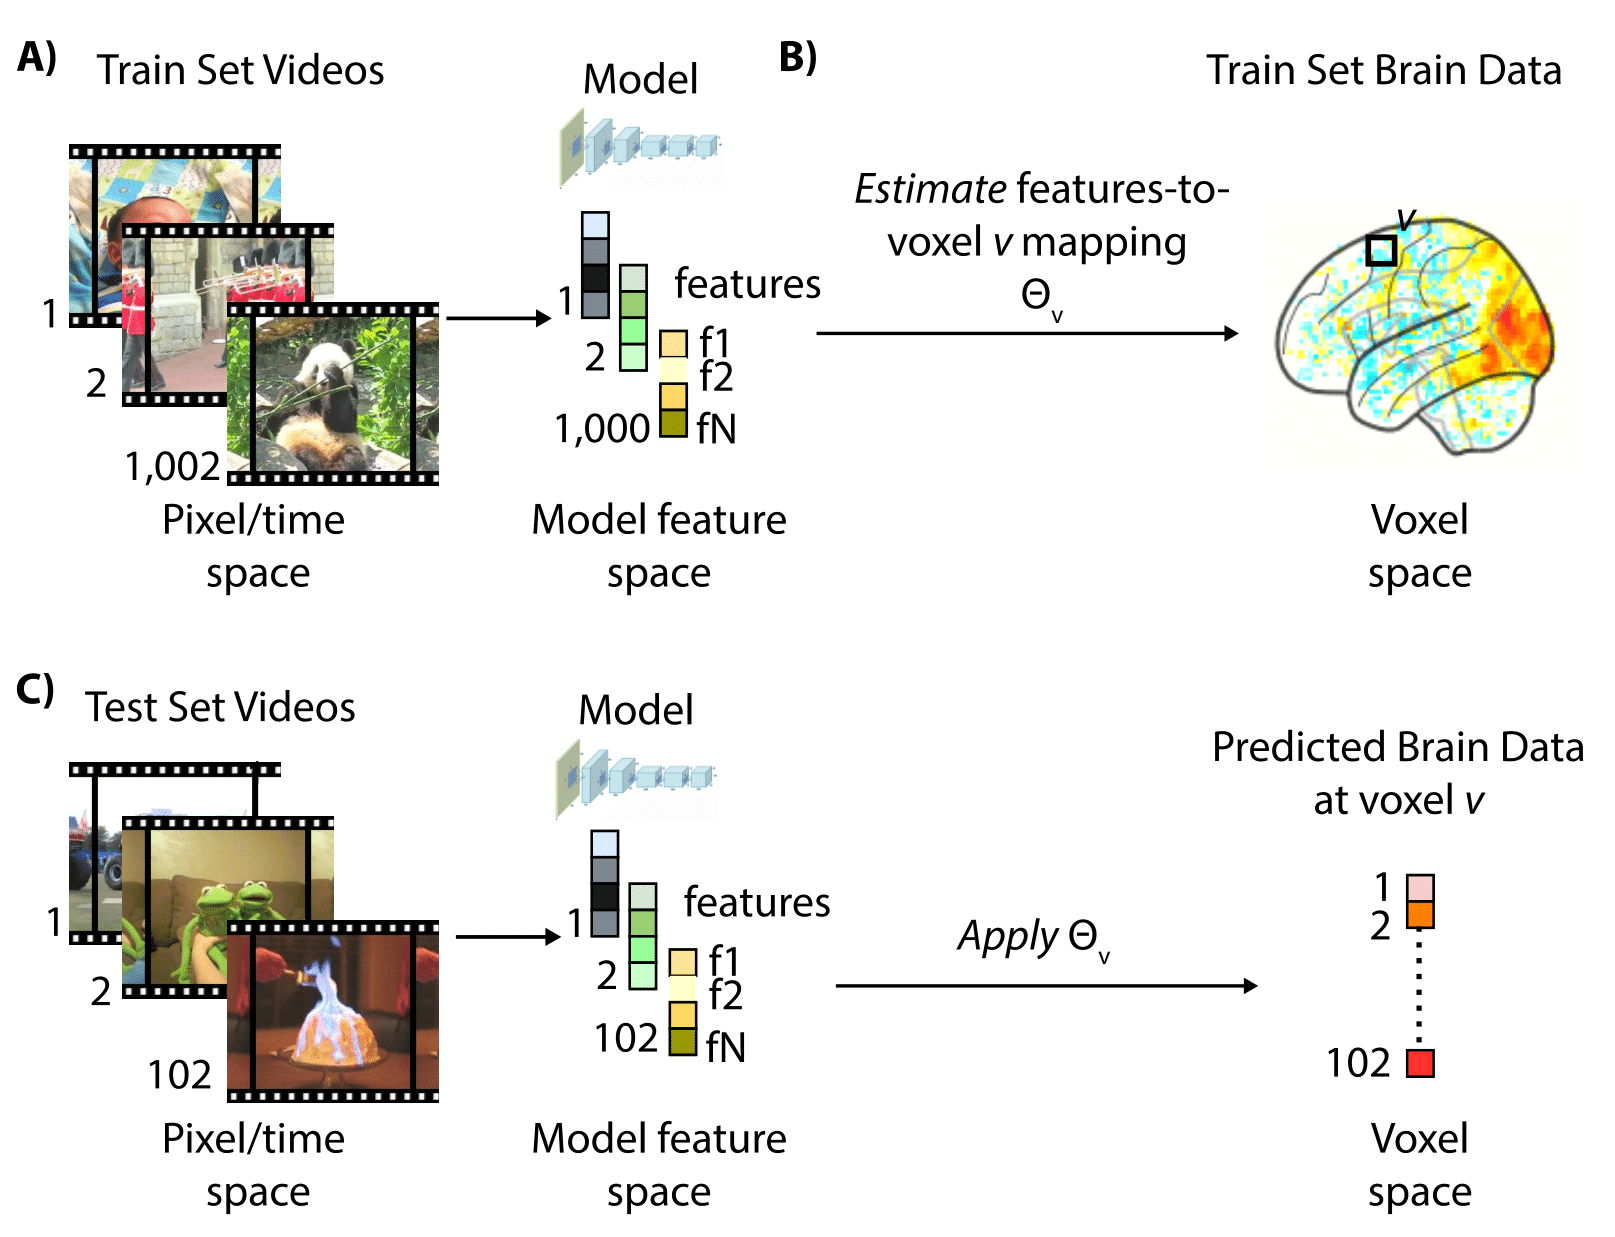

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

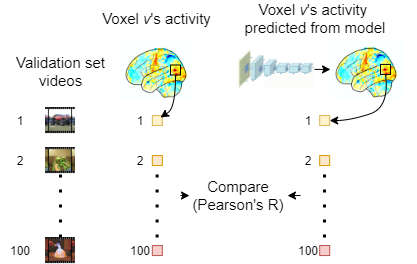

### Perform and evaluate encoding on validation set

The average score on the brain surface display takes a while to load, be patient!

In [ ]:
from Buzznauts.analysis.baseline import perform_encoding
from IPython.display import HTML, display

sub = ["sub01", "sub02", "sub03", "sub04", "sub05", "sub06", "sub07", "sub08", "sub09", "sub10"]
sub=widgets.Dropdown(options=sub, value="sub04", description="Subject")

layer = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]
layer=widgets.Dropdown(options=layer, value="layer_5", description="Layer")

ROI = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
ROI=widgets.Dropdown(options=ROI, value="WB", description="ROI")

@widgets.interact(activations_dir=widgets.fixed(activations_pca_dir)
                  results_dir=widgets.fixed(results_dir),
                  fmri_dir=widgets.fixed(fmri_dir), sub=sub,
                  layer=layer, ROI=ROI, device=widgets.fixed(device),
                  viz_dir=widgets.fixed(viz_baseline_dir)) 
def vizualize_fmri_predictions(activations_dir, results_dir, fmri_dir, sub="sub04",
                               layer="layer_5", ROI="WB", device=device, viz_dir=viz_dir):
    
    score, view_html = perform_encoding(activations_dir, results_dir, fmri_dir, 
                                        sub, layer, ROI=ROI, device=device, viz_dir=viz_dir)
    
    score_box_layout = Layout(display='flex', flex_flow='column', align_items='stretch',
                              border='solid', width='75%')
    surf_box_layout = Layout(display='flex', flex_flow='column', align_items='stretch',
                              border='solid', width='75%')
    
    score_text = f'<p>Mean correlation for ROI: {ROI} in {sub} is: <b>{score:.6f}</b></p>'
    score = widgets.HTML(value=score_text)
    surf = HTML(filename=view_html)
    score_box = HBox([score], layout=score_box_layout) 
    display(score_box)
    display(surf)

If you use the default parameters (sub04, WB, layer_5) you should obtain a correlation of 0.056 between predicted and recorded fMRI responses on validation videos.

# Predict fMRI responses to test videos for all subjects and all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
subs = ["sub01", "sub02", "sub03", "sub04", "sub05", "sub06", "sub07", "sub08", "sub09", "sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
for sub in tqdm(subs):
    print (f"Starting sub: {sub}")
    for ROI in ROIs:
        perform_encoding(activations_pca_dir, results_dir, fmri_dir, 
                         sub, layer="layer_5", ROI=ROI, mode='test',
                         visualize_results=False, device=device)
    print (f"Completed sub: {sub}")
    print("-----------------------------------------------")

In [ ]:
from Buzznauts.app.prepare_submission import prepare_results

results_layer5_dir = op.join(results_dir, 'layer_5')
submission_dir = "/contents/submission/baseline"
prepare_results(results_layer5_dir, submission_dir, track='full_track')
prepare_results(results_layer5_dir, submission_dir, track='mini_track')

Click the folder button on the left panel and you should see zipfiles ready for submission at:

`submission/baseline/full_track`

`submission/baseline/mini_track`

# Reference

[The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. 
*Cichy et al. arxiv 2021*](https://arxiv.org/abs/2104.13714v1)